# Testing Some Models

## Setting up

In [1]:
import os
import numpy as np
import pandas as pd
import math
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Flatten, Concatenate
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
outcomes = ['No Finding',
            'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
            'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
            'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
            'Support Devices']

PATH = '/Volumes/GBackup/Data/CheXpertDataset'

## Preprocessing

In [3]:
def edit_urls(url):
    ''' a function to edit the urls to the correct path
    '''
    pieces = url.split('/')
    newurl = ''

      #removing the previous path 'CheXpert-v1.0-small' and including the PATH
    for i, piece in enumerate(pieces):
        if i > 0:
            newurl+= '/' + piece
        elif i == 0:
            newurl += PATH

    return newurl

def clean_data(df):
    '''
    Edits the urls, fills the 'maybes' with yes and the nulls with no,
    removes outlier ages (age 0 patients), removes 'unknown gender' patients,
    collects which type of image it is
    '''
    df['Path'] = df['Path'].apply(edit_urls)
    df[outcomes] = df[outcomes].fillna(0)
    df[outcomes] = df[outcomes].replace(-1,1)
    df = df[df['Age'] > 1]
    df = df[(df['Sex'] == 'Male') | (df['Sex'] == 'Female')]
    df['Image Type'] = df['AP/PA'].fillna('Lateral')
    return df

### Upload the csv

In [4]:
df = pd.read_csv(PATH + '/train.csv')
df = clean_data(df)
df.head(10)

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,Image Type
0,/Volumes/GBackup/Data/CheXpertDataset/train/pa...,Female,68,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,AP
1,/Volumes/GBackup/Data/CheXpertDataset/train/pa...,Female,87,Frontal,AP,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,AP
2,/Volumes/GBackup/Data/CheXpertDataset/train/pa...,Female,83,Frontal,AP,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,AP
3,/Volumes/GBackup/Data/CheXpertDataset/train/pa...,Female,83,Lateral,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Lateral
4,/Volumes/GBackup/Data/CheXpertDataset/train/pa...,Male,41,Frontal,AP,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AP
5,/Volumes/GBackup/Data/CheXpertDataset/train/pa...,Female,20,Frontal,PA,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PA
6,/Volumes/GBackup/Data/CheXpertDataset/train/pa...,Female,20,Lateral,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Lateral
7,/Volumes/GBackup/Data/CheXpertDataset/train/pa...,Male,33,Frontal,PA,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,PA
8,/Volumes/GBackup/Data/CheXpertDataset/train/pa...,Male,33,Lateral,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Lateral
9,/Volumes/GBackup/Data/CheXpertDataset/train/pa...,Male,33,Frontal,AP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,AP


In [5]:
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
sns.set(style='white')

/Volumes/GBackup/Data/CheXpertDataset/train/patient00001/study1/view1_frontal.jpg


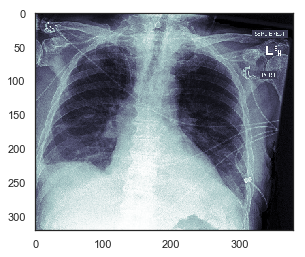

Opening 15 images took 0.7406308650970459 seconds to run


In [8]:
import time


print(tester_url)

start = time.time()

for i in range(15):
    tester_url = df.iloc[i][0]
    xray = Image.open(tester_url)
end = time.time()

plt.imshow(xray, cmap = "bone")
plt.show()

print('Opening 15 images took', (end-start), 'seconds to run')

## Preprocessing for the Model

In [40]:
def bunch_nonimage_features(df, 
                            colheaders, 
                            batch_size):
    '''
    Creates a batch with (hopefully) the same batches as the 
    train_generator, to hold nonimage features from the dataframe

    The desired shape will be:
    array - shape numbatches
    array[0] - the number of columns of data
    array[0][0] - data for the first column (one piece of data for each member of the batch)
    so the shape would be:
    (numbatches, numfeatures, batch_size)

    Because this is a numpy array, all features must be numeric.
    '''

    for feat in colheaders:
        assert df[feat].dtype in ['int', 'int8', 'int64'], f'Features must be numeric. {feat} is type {df[feat].dtype}'

    #use ceiling because we need extras
    numbatches = math.ceil(len(df) / batch_size)
    numfeatures = len(colheaders)

    #making an empty array to fill in with the information of the batches
    feats_generator = np.zeros( (numbatches, numfeatures, batch_size) )

    #using a for loop but I wonder if there's a way to do it better?
    for i in range(numbatches):
        startindex = i * batch_size

        #if the data doesn't fit evenly into the bunches, manually insert it
        if startindex + batch_size > len(df):
            numleftover = startindex + batch_size - len(df) - 1
            for counter, feat in enumerate(colheaders):
                for j in range(0, numleftover):
                    feats_generator[i][counter][j] = df[feat].iloc[startindex + j]

        else:
            stopindex = startindex + batch_size
            for counter, feat in enumerate(colheaders):
                feats_generator[i][counter] = df[feat].iloc[startindex:stopindex].values

    print(f'Collected {numfeatures} feature(s) for {len(df)} images.')
    return feats_generator


def create_generators(df, datagen, path_col_header, feat_col_headers, target_header, batch_size, 
                      image_size= (256,256), color_mode = 'grayscale', class_mode = 'binary', SEED=None ):
    '''
    Takes in the things that we use for making a flow_from_dataframe generator, plus makes a feature array
    for non-image features.
    '''
    if SEED == None:
        #generate a random seed that will be constant
        SEED = np.random.randint(0,100)

    #sampling all of it gets a shuffled dataframe
    df_shuffled = df.sample(frac=1, random_state = SEED)

    #we need the length to perfectly fit the batch size so we're cutting off the extras 
    #sorry if this is bad practice
    numbatches = math.ceil(len(df_shuffled) // batch_size)
    corrected_length = numbatches * batch_size
    df_shuffled = df_shuffled.iloc[0:corrected_length]

    print(f'{len(df) - corrected_length} samples were removed.')

    #get the features before we change the type to string
    feats_gen = bunch_nonimage_features(df_shuffled, feat_col_headers, batch_size)
    
    #then change the types to strings because the flow_from_dataframe needs them to be strings
    if type(target_header) == list:
        for targ in target_header:
            df_shuffled[targ] = df_shuffled[targ].apply(str)
    else:
        df_shuffled[target_header] = df_shuffled[target_header].apply(str)

    train_generator = datagen.flow_from_dataframe(
        df_shuffled, 
        x_col = path_col_header, 
        y_col = target_header, 
        target_size= image_size, 
        color_mode= color_mode, 
        class_mode= class_mode, 
        batch_size=batch_size, 
        shuffle=False,
        seed=SEED, 
    )

    print( f'{numbatches} batches created' )

    return (train_generator, feats_gen)

def make_iterator(image_generator, feature_generator):
    '''
    Used to properly use the image and feature generators with the custom non-image feature models
    '''
    #first make a feature generator for my feature array
    feat_gen = (
        featgen[i]
        for i in range(len(featgen))
    )
    while True:
            imgnext = image_generator.next()
            feats = next(feat_gen)
            yield [ imgnext[0], feats[0] ], imgnext[1]  #Yield the image, the features, and the labels (from features)


## The Model

In [6]:
def model_with_nonimage_features(im_shape, feats_shape):
    '''
    This model takes in the image data and the feature data.
    '''
    #create the inputs
    img_input = Input(shape=im_shape, name='images')
    feat_input = Input(shape=feats_shape, name='xtrafeatures')

    #create the layers
    #the image layers
    x = Conv2D(32, kernel_size=3, activation='relu', input_shape=im_shape) (img_input)
    x = Flatten()(x)

    #the other features layer
    y = Dense(4, activation='relu')( feat_input )

    #add the image and the features together and have another layer on top
    added = Concatenate(axis=-1)([x, y])
    # z = Dense(8, activation='relu') (added)

    #the final layer
    predictions = Dense(2, activation=tf.nn.softmax)(added)

    #create the model and return it
    return Model(inputs=[img_input, feat_input], outputs=predictions)


## Use the model

In [41]:
#split into a training and testing set
train_df, val_df = train_test_split( df, test_size=0.2)

#convert non-image features to numeric features :)
train_df['Sex'] = train_df['Sex'].astype('category').cat.codes
train_df['Image Type'] = train_df['Image Type'].astype('category').cat.codes

#actually make a smaller sample set to test
train_sample = train_df.sample(frac=0.2, random_state = 12)

IMG_SIZE = (256,256,1)
nonimg_feats = ['Age', 'Sex', 'Image Type']
num_nonimg_feats = len(nonimg_feats)

model = model_with_nonimage_features( IMG_SIZE, (1,) )
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.train.AdamOptimizer(),
    metrics=['accuracy']
)

/Users/gabimuir/anaconda2/envs/django/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/gabimuir/anaconda2/envs/django/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [43]:
#load the data for the model
imgen, featgen = create_generators(
    train_sample,
    datagen = ImageDataGenerator(rescale=1./255),
    path_col_header = 'Path',
    feat_col_headers = nonimg_feats,
    target_header = 'No Finding',
    batch_size = 32,
    class_mode = 'binary'
)

2 samples were removed.
Collected 3 feature(s) for 35744 images.
Found 35744 validated image filenames belonging to 2 classes.
1117 batches created


In [44]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 254, 254, 32) 320         images[0][0]                     
__________________________________________________________________________________________________
xtrafeatures (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 2064512)      0           conv2d_10[0][0]                  
__________________________________________________________________________________________________
dense_19 (

In [ ]:
myiterator = make_iterator(imgen, featgen)
history = model.fit_generator(
        myiterator,
        steps_per_epoch=1000,
        epochs=5,
        validation_data=None
)

Epoch 1/5
 286/1000 [=======>......................] - ETA: 19:54 - loss: 1.5821 - acc: 0.9014